
Kruskal-Wallis Test für Bezirk 1...

Kruskal-Wallis Test für Bezirk 2...

Kruskal-Wallis Test für Bezirk 3...

Kruskal-Wallis Test für Bezirk 4...

Kruskal-Wallis Test für Bezirk 5...

Kruskal-Wallis Test für Bezirk 6...

Kruskal-Wallis Test für Bezirk 7...

Kruskal-Wallis Test für Bezirk 8...

Kruskal-Wallis Test für Bezirk 9...

Kruskal-Wallis Test für Bezirk 10...

Kruskal-Wallis Test für Bezirk 11...

Kruskal-Wallis Test für Bezirk 12...

Kruskal-Wallis Test Ergebnisse pro Bezirk:
      BEZ      Feature  H-statistic        p-value
7      1      IstFuss  7413.048823   0.000000e+00
11     1         UART  5947.821971   0.000000e+00
12     1        UTYP1  2099.693683   0.000000e+00
5      1       IstRad   701.874774  8.232212e-152
6      1       IstPKW   678.445535  9.902852e-147
..   ...          ...          ...            ...
179   12  USTRZUSTAND    19.453853   2.202446e-04
167   12      USTUNDE     9.240387   2.625979e-02
166   12       UMONAT     7.616106   5.464905e-02
165   12

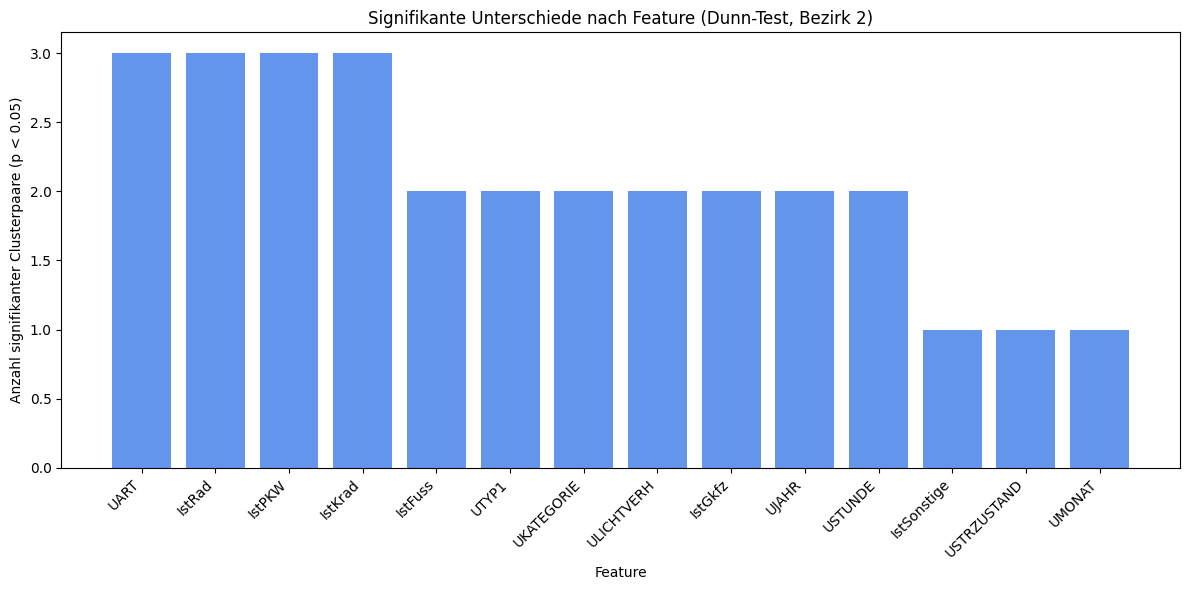

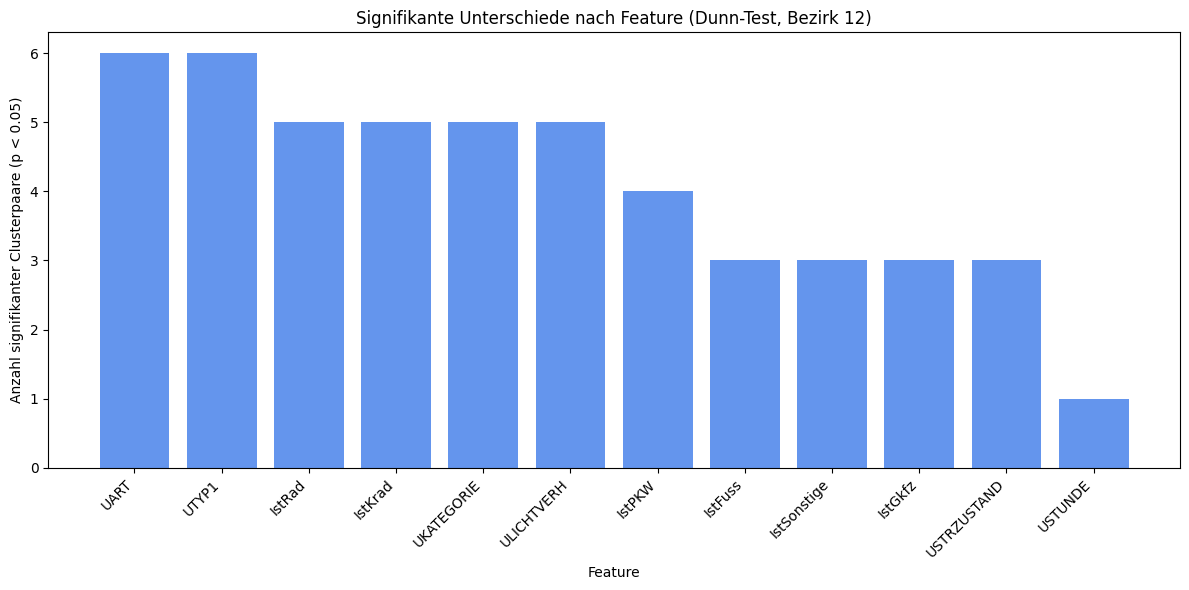

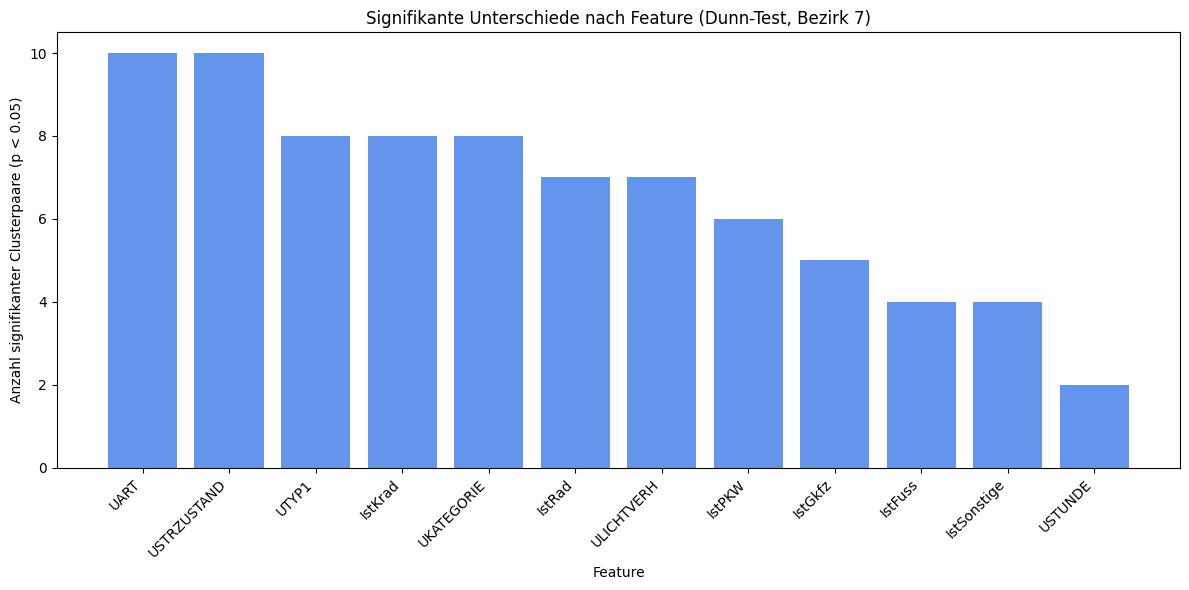

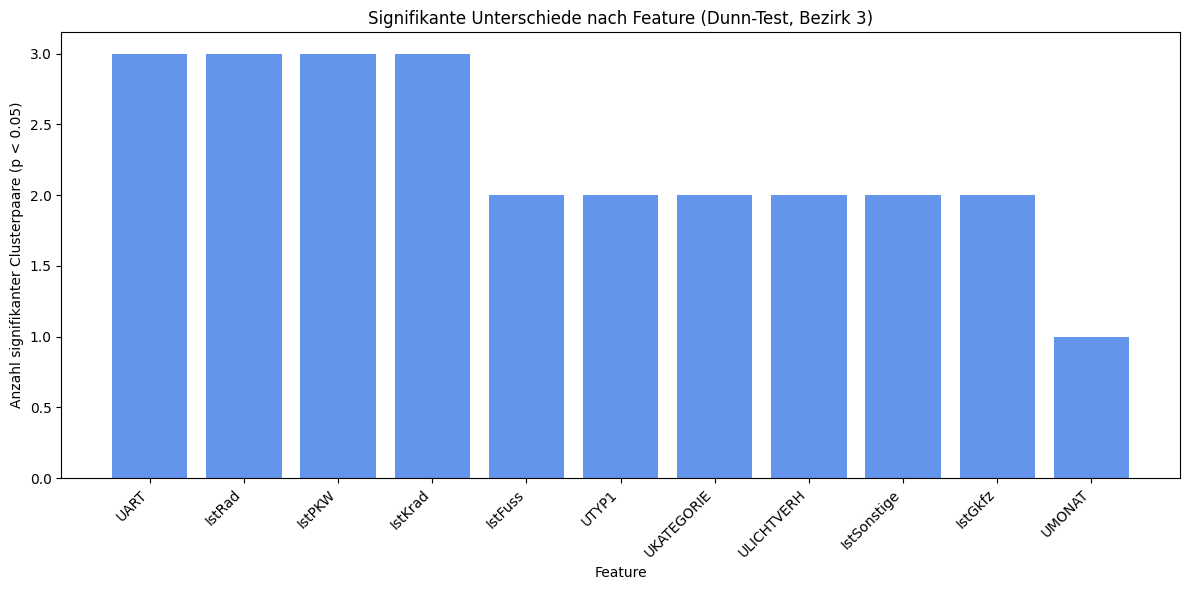

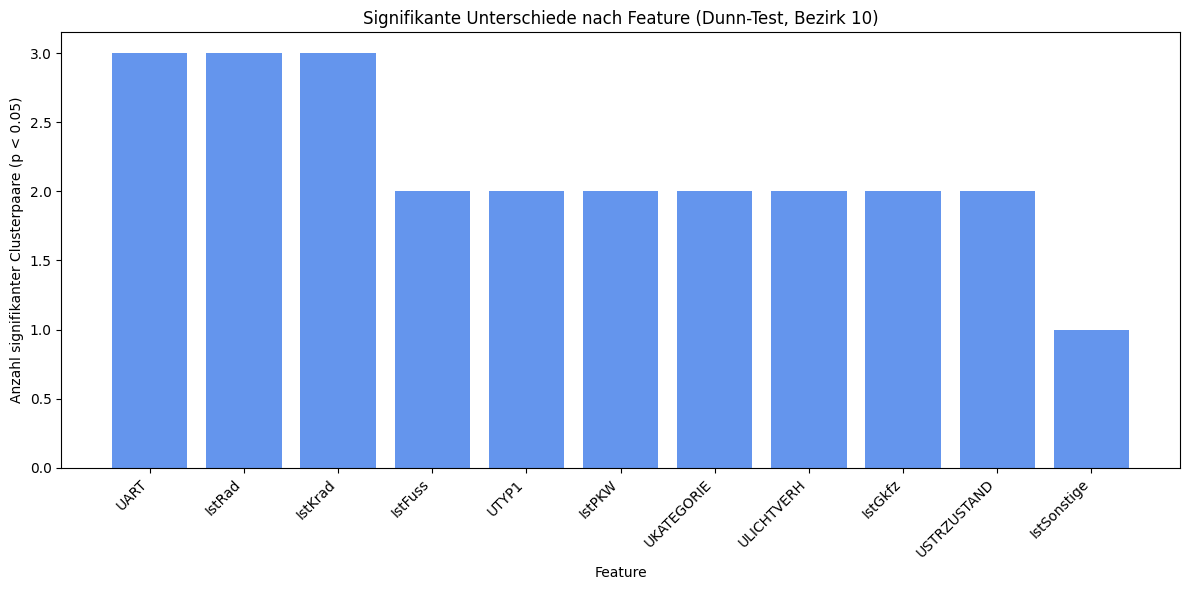

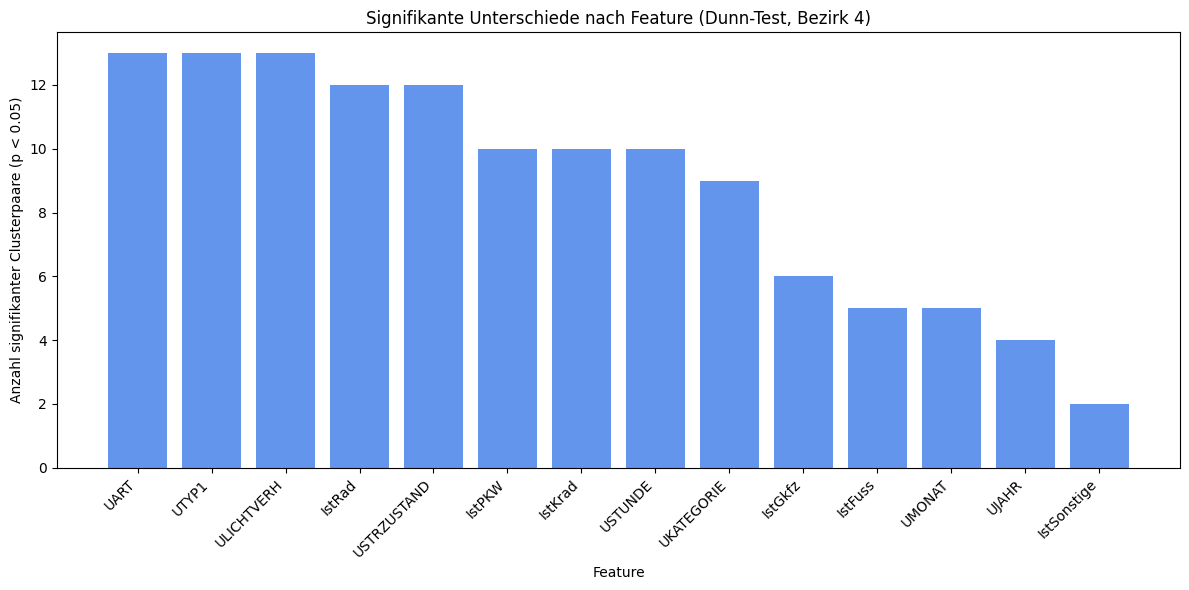

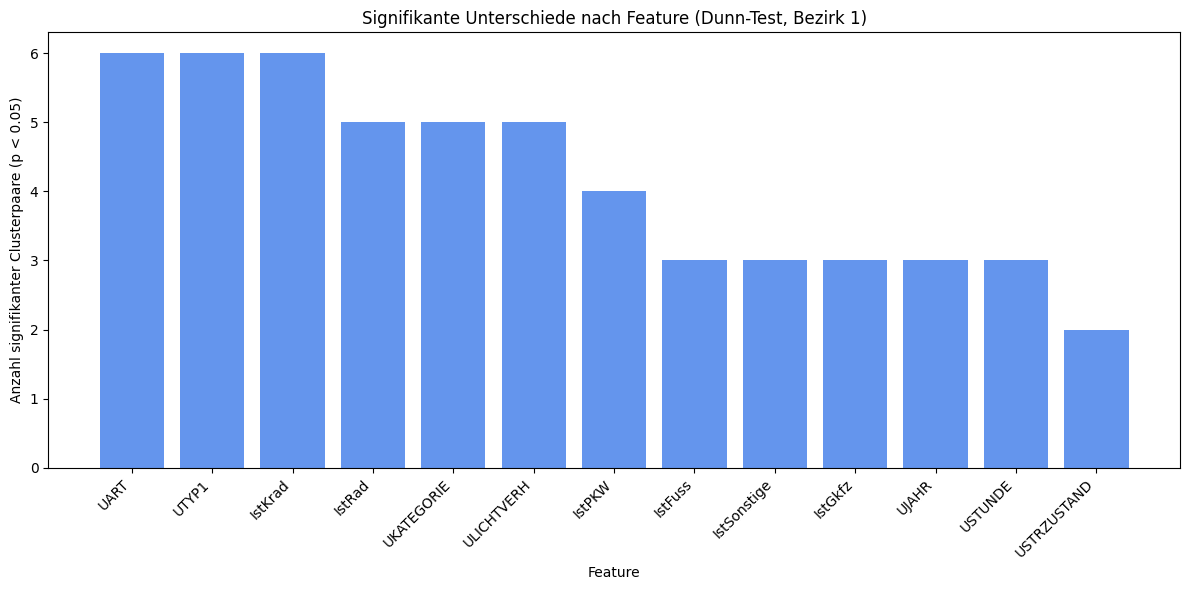

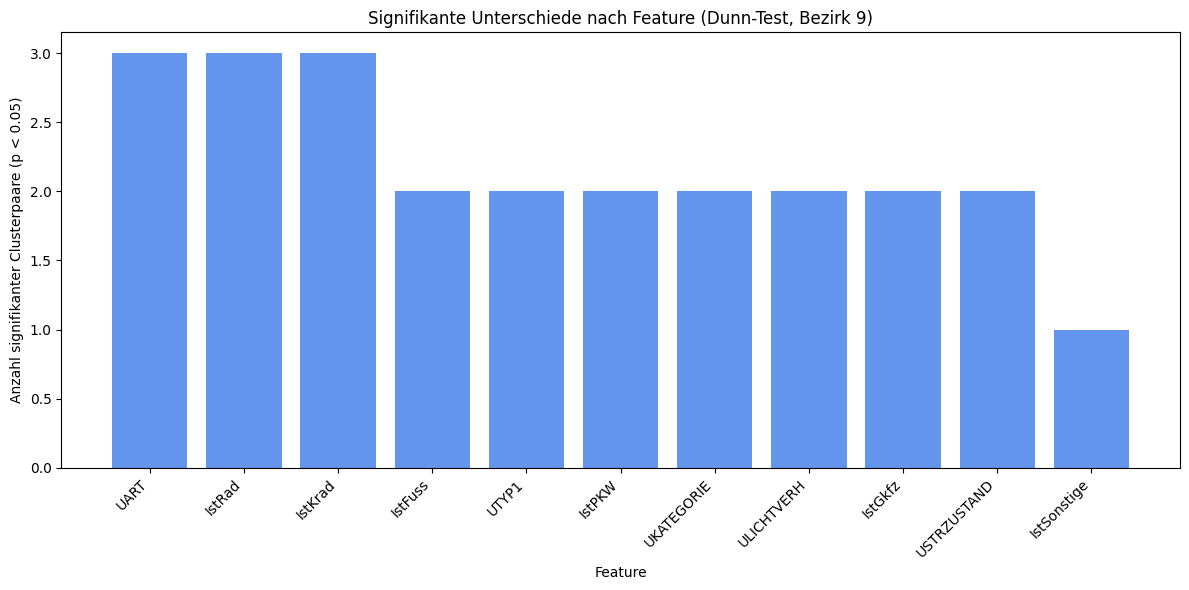

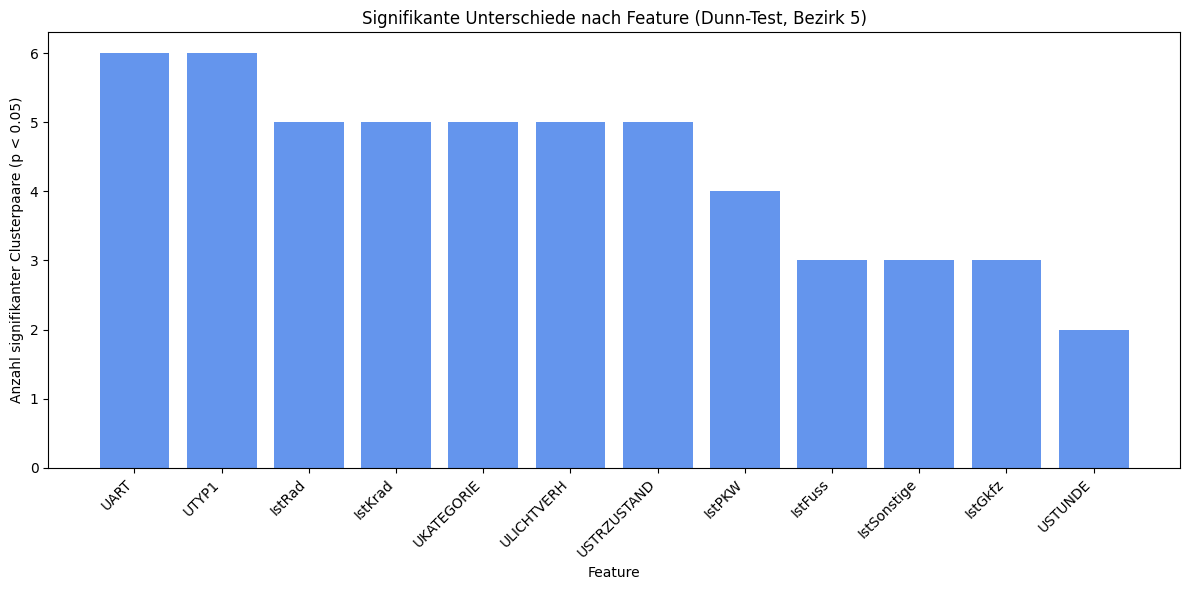

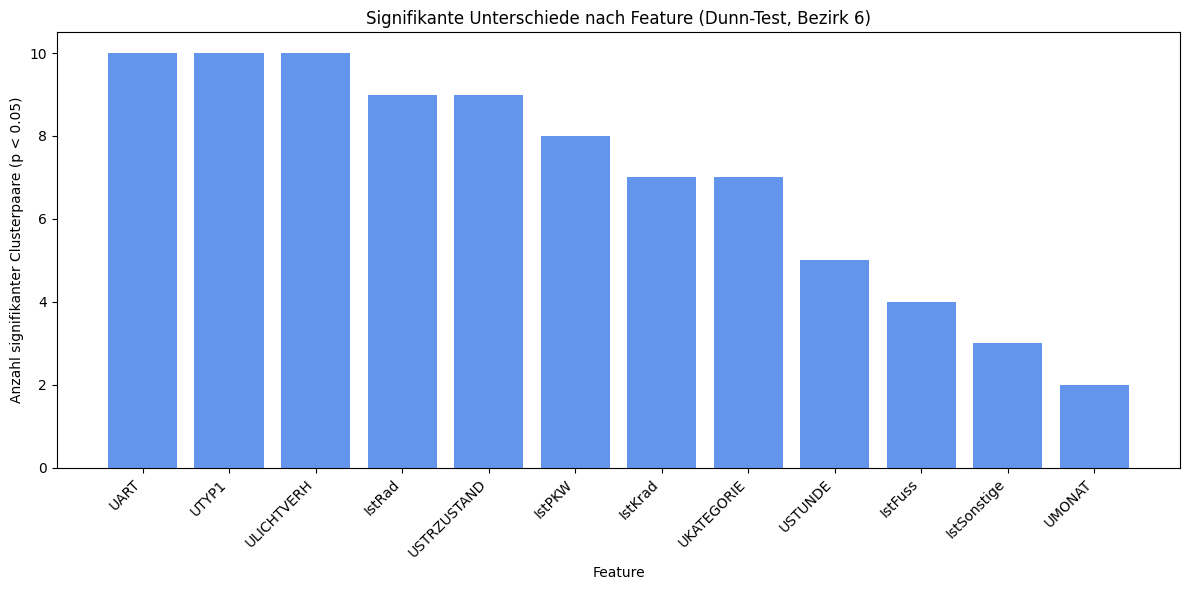

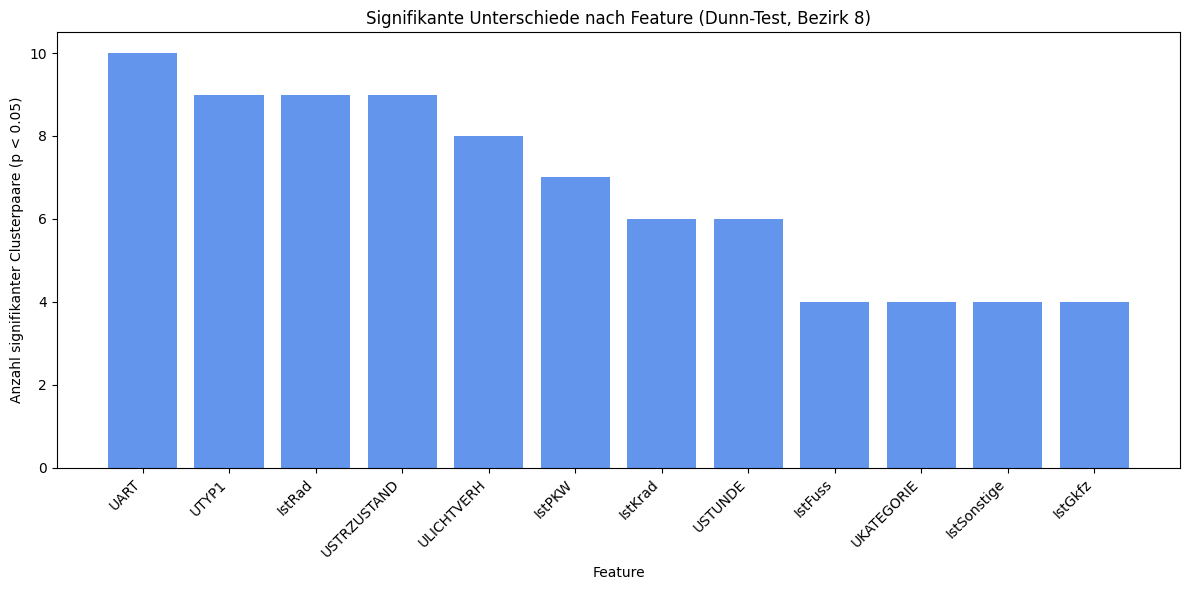

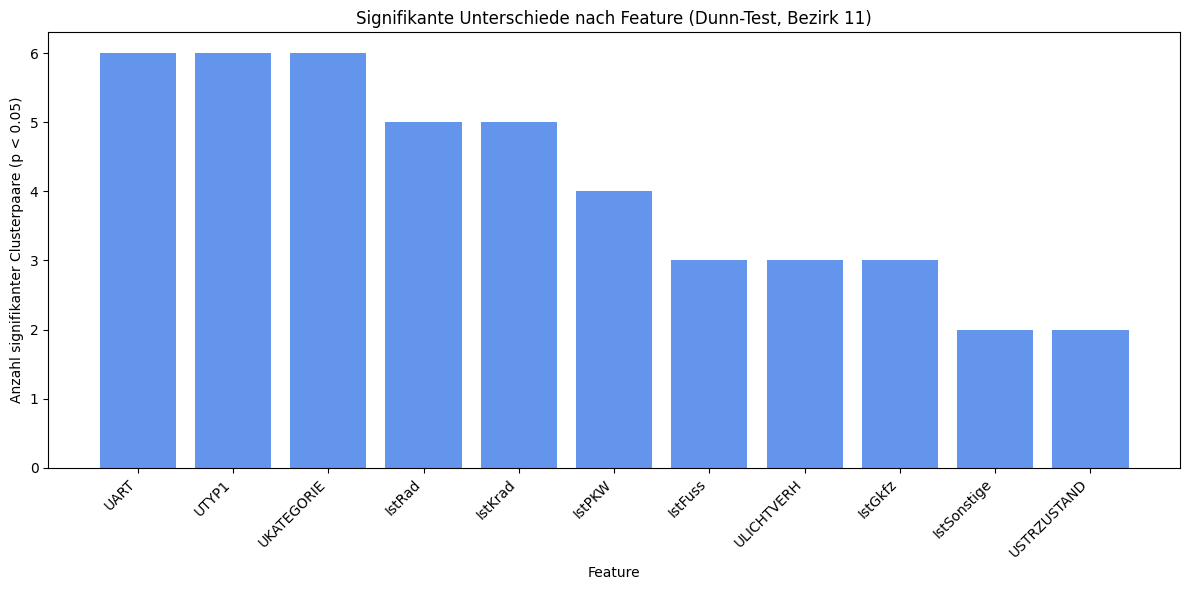

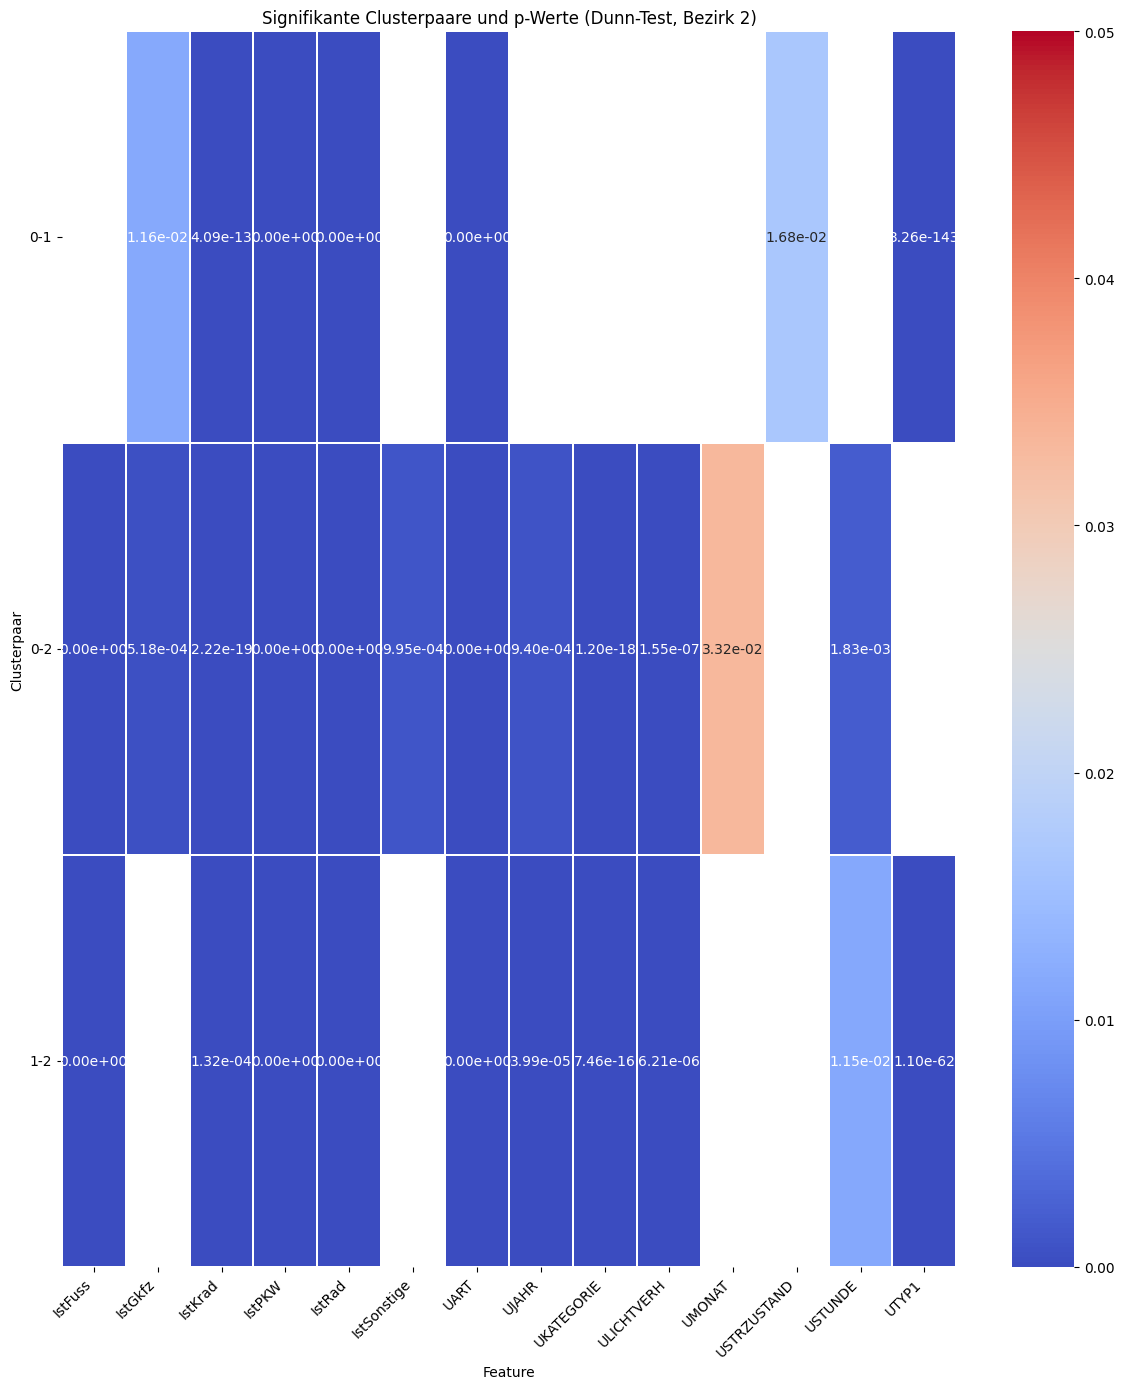

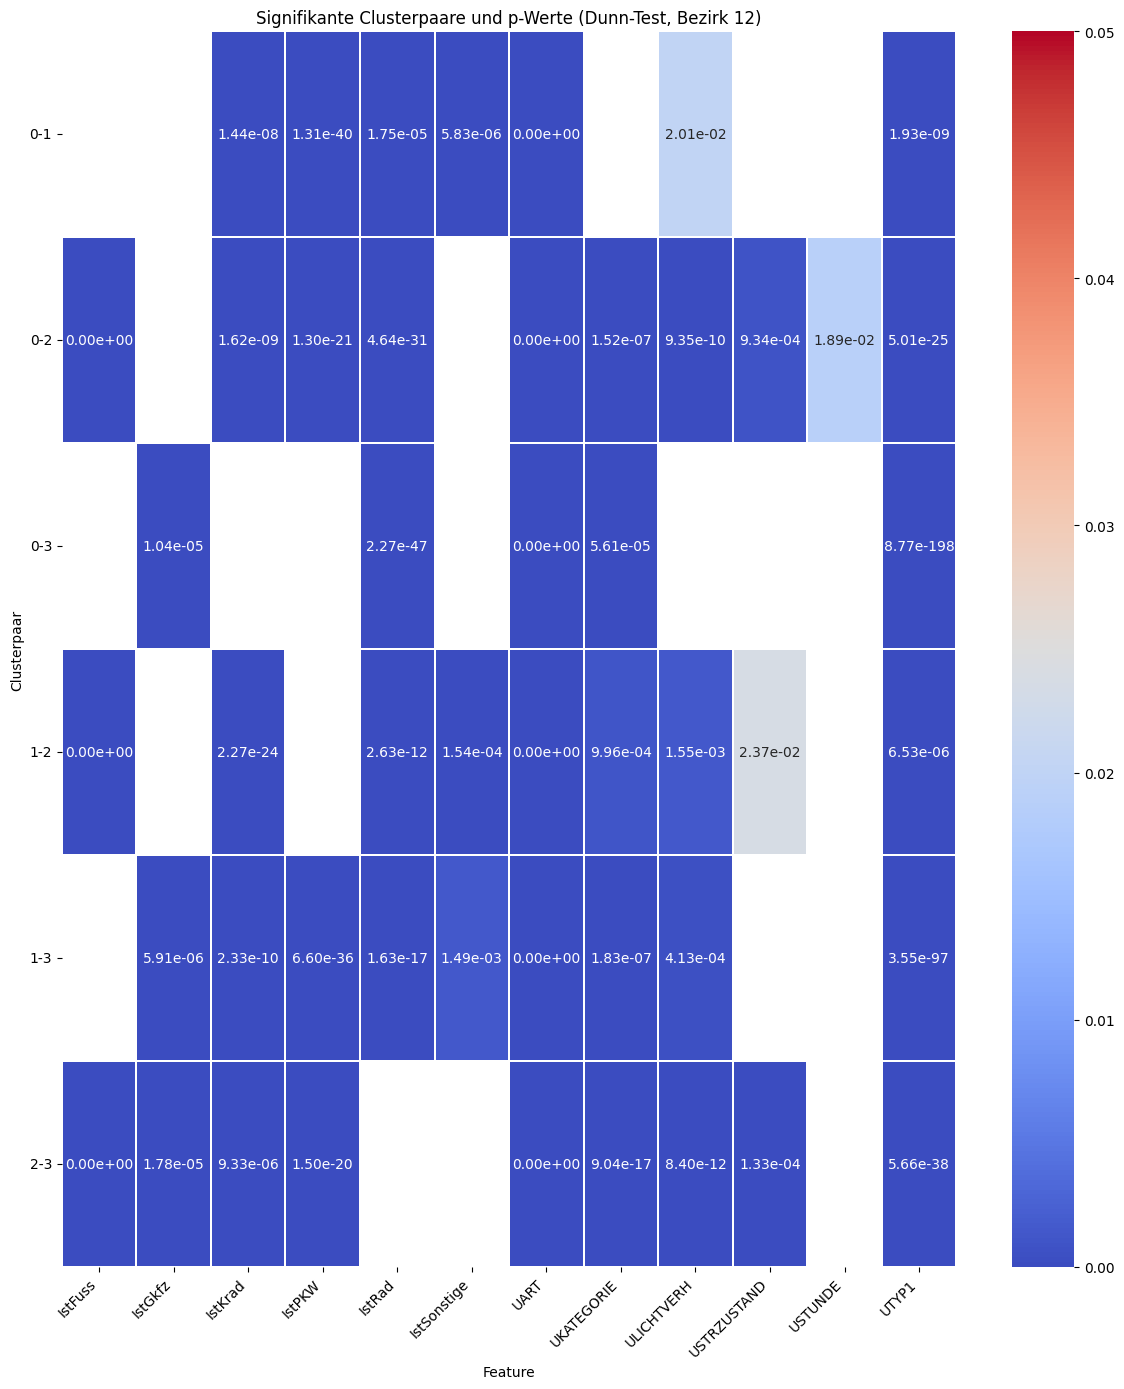

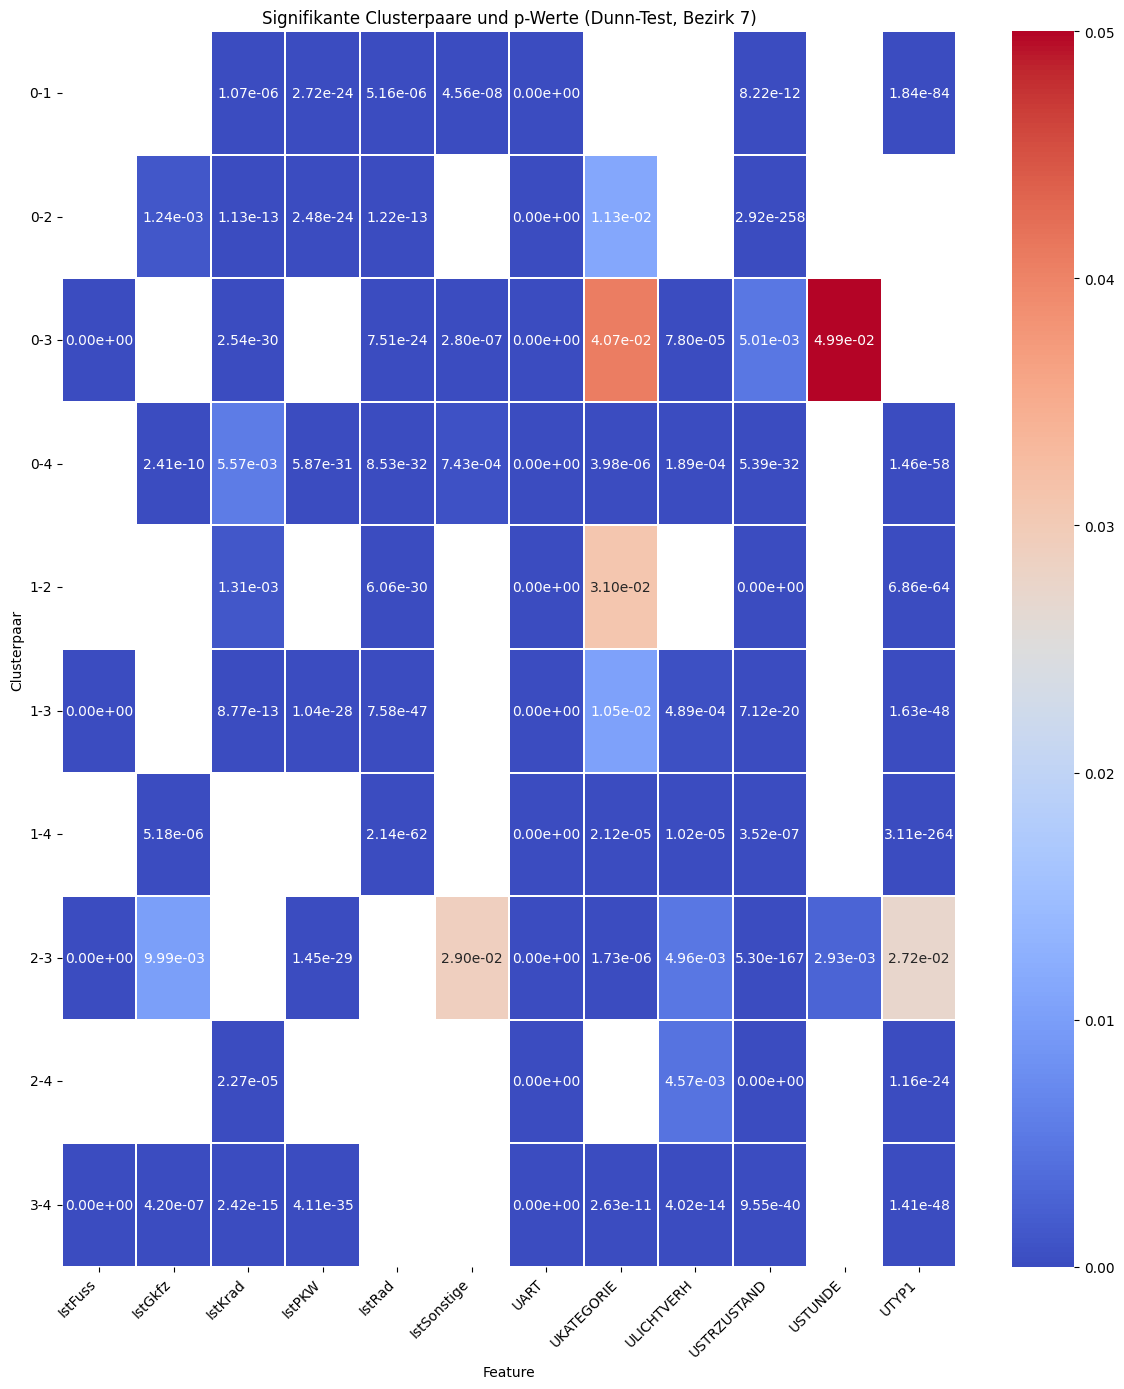

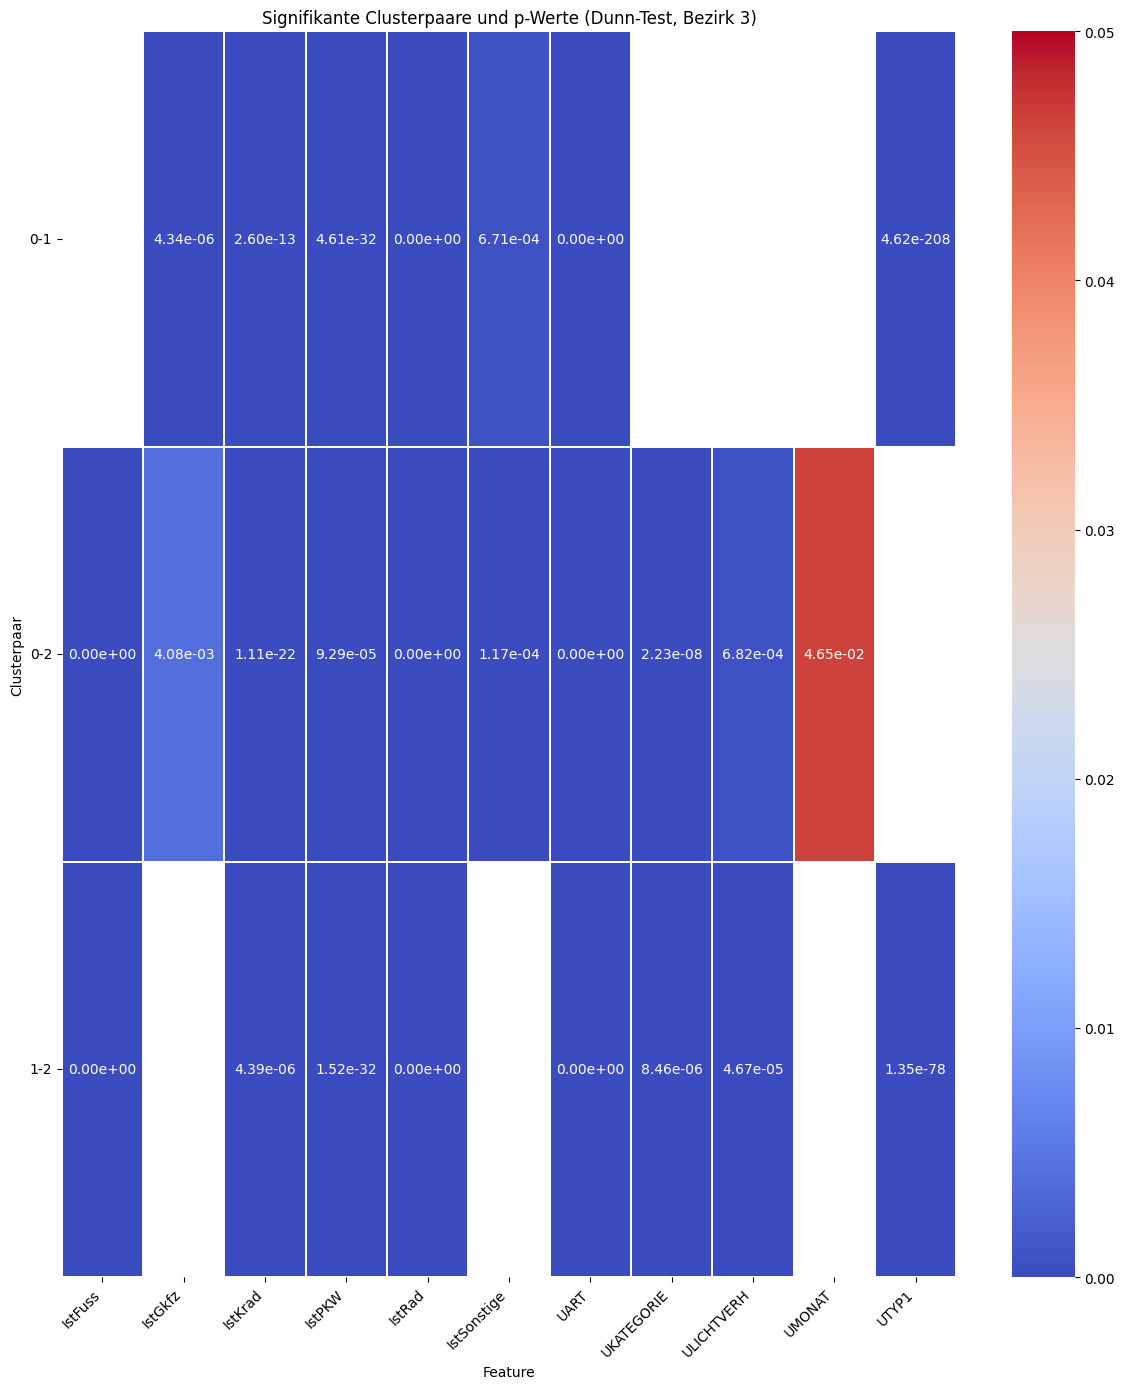

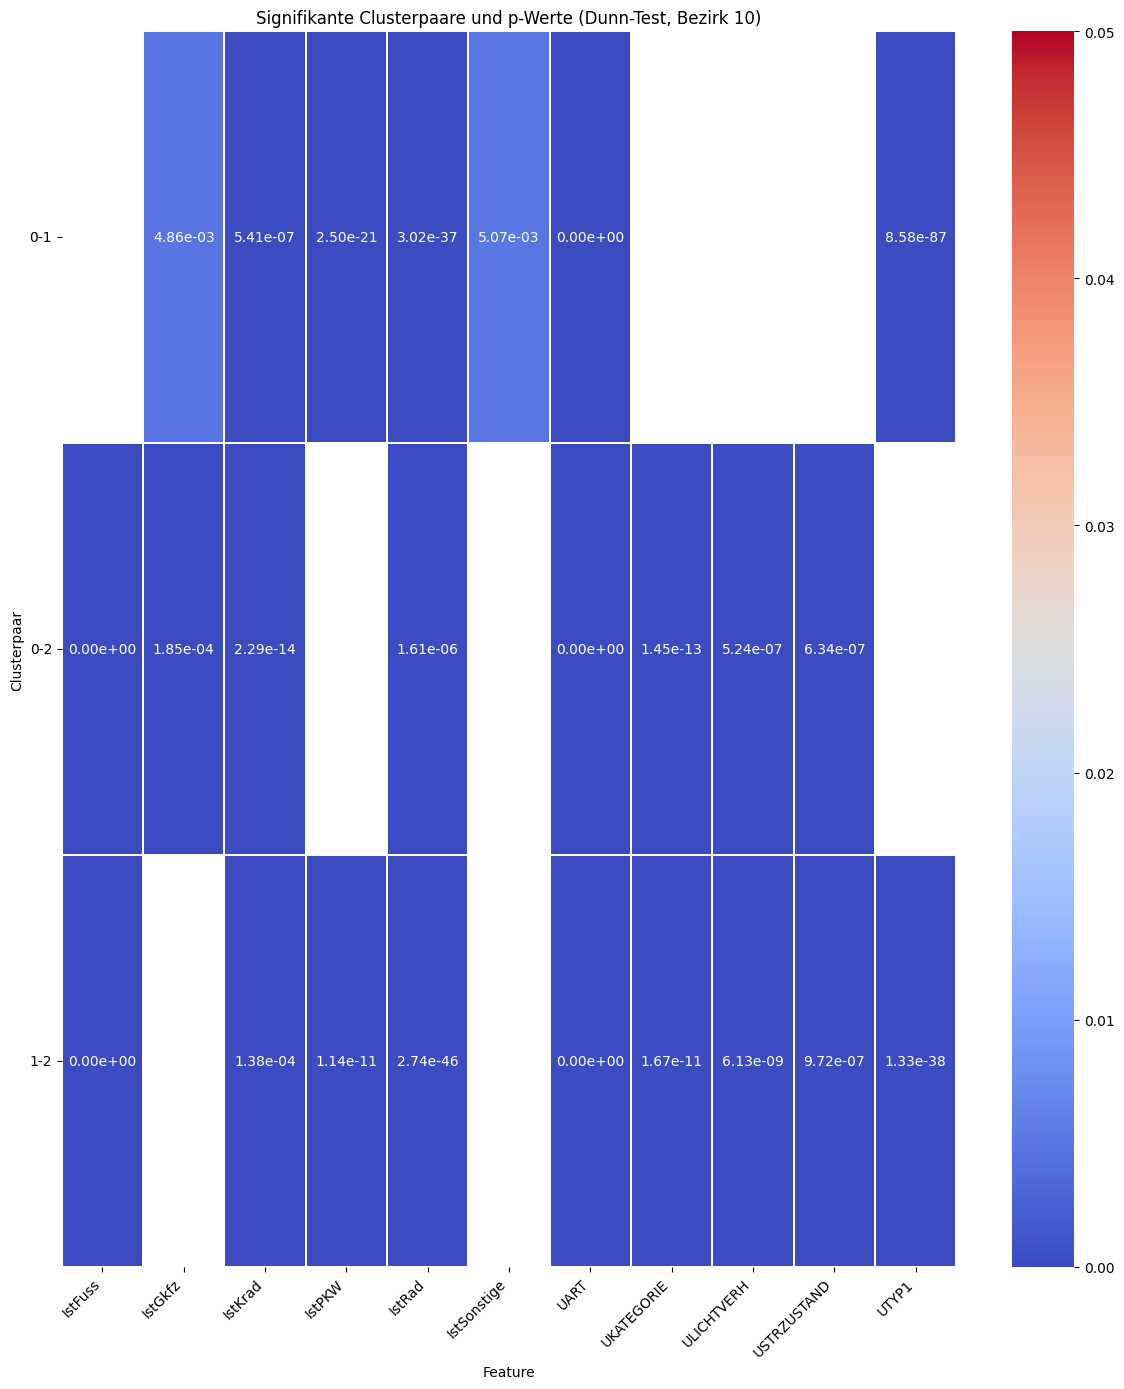

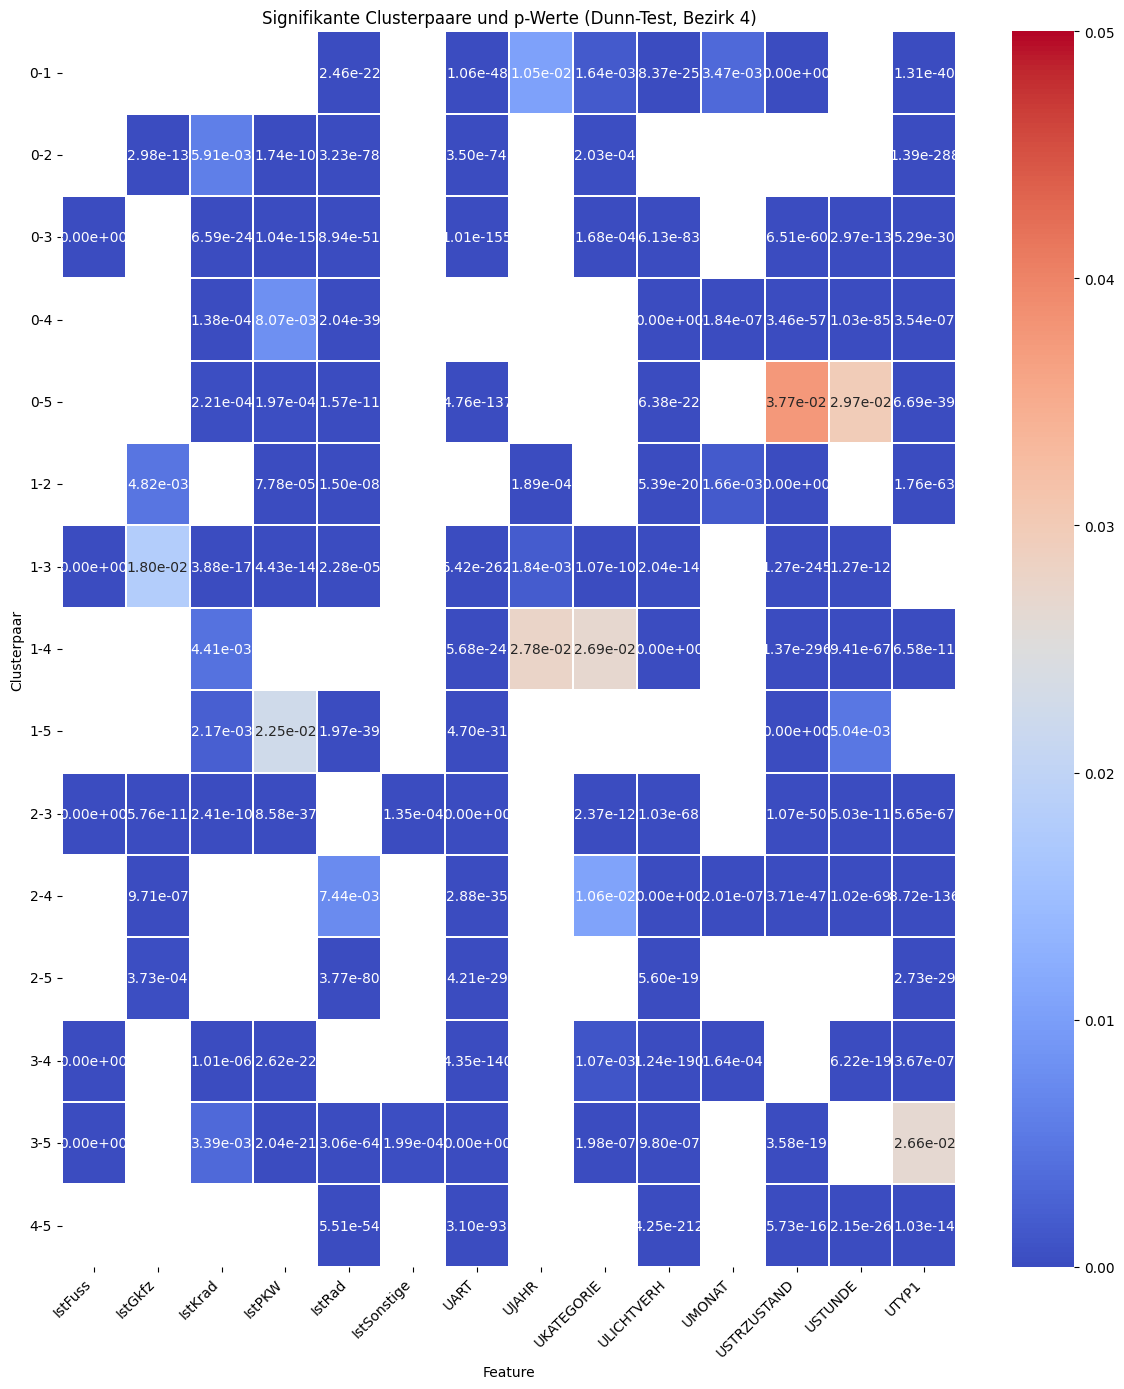

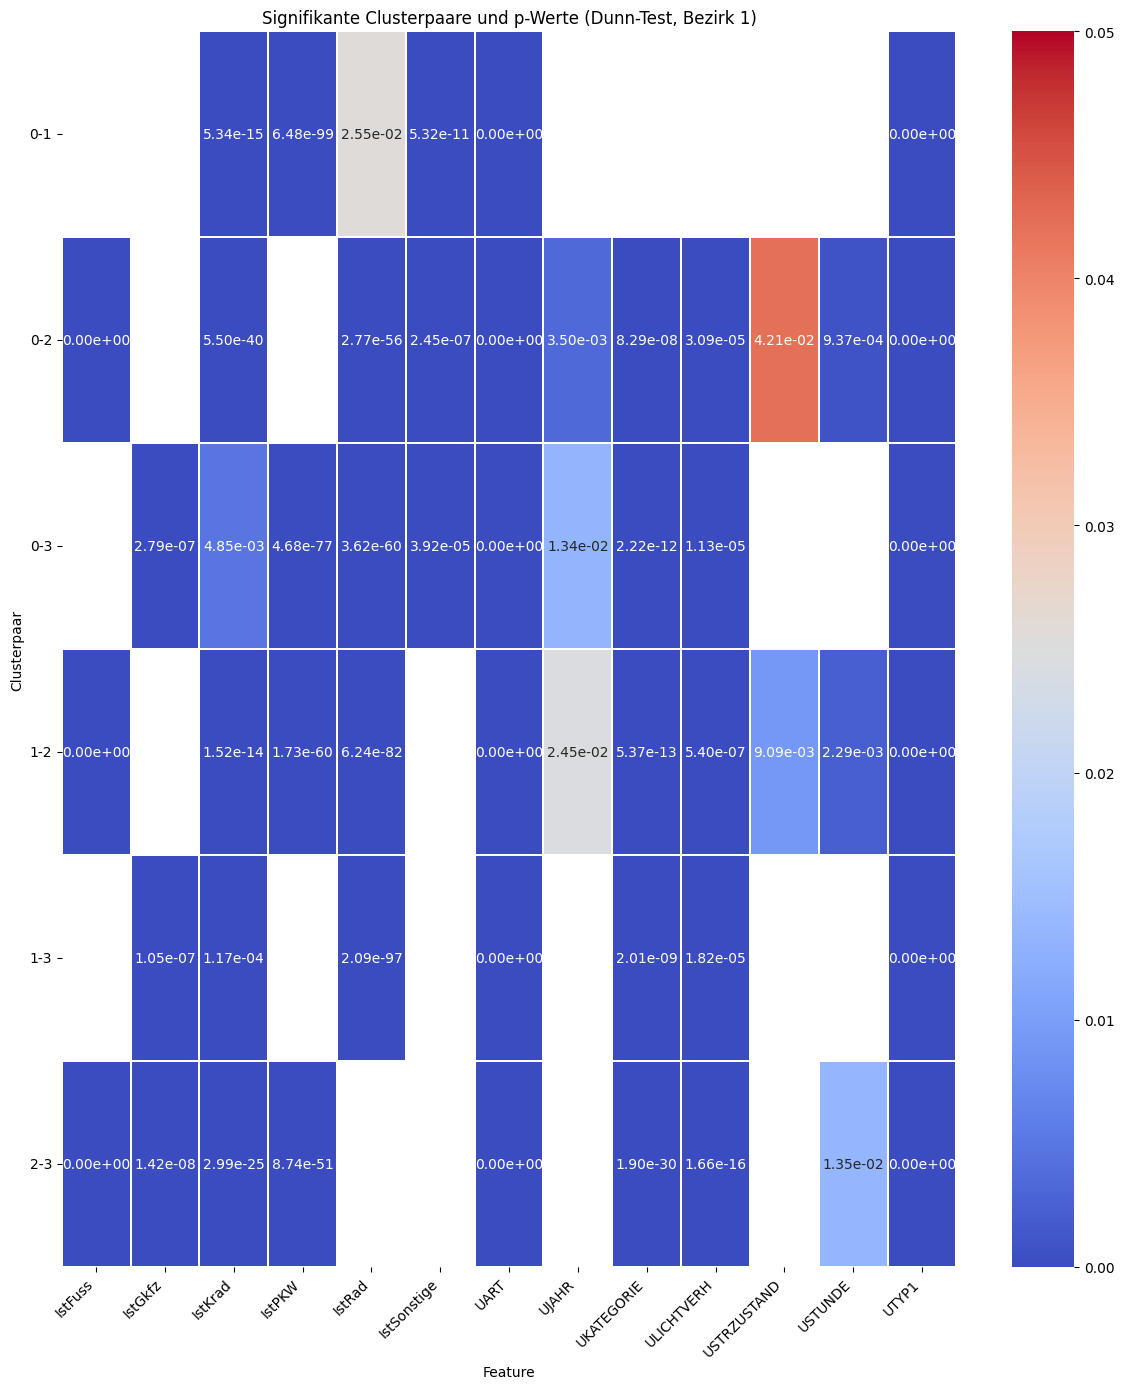

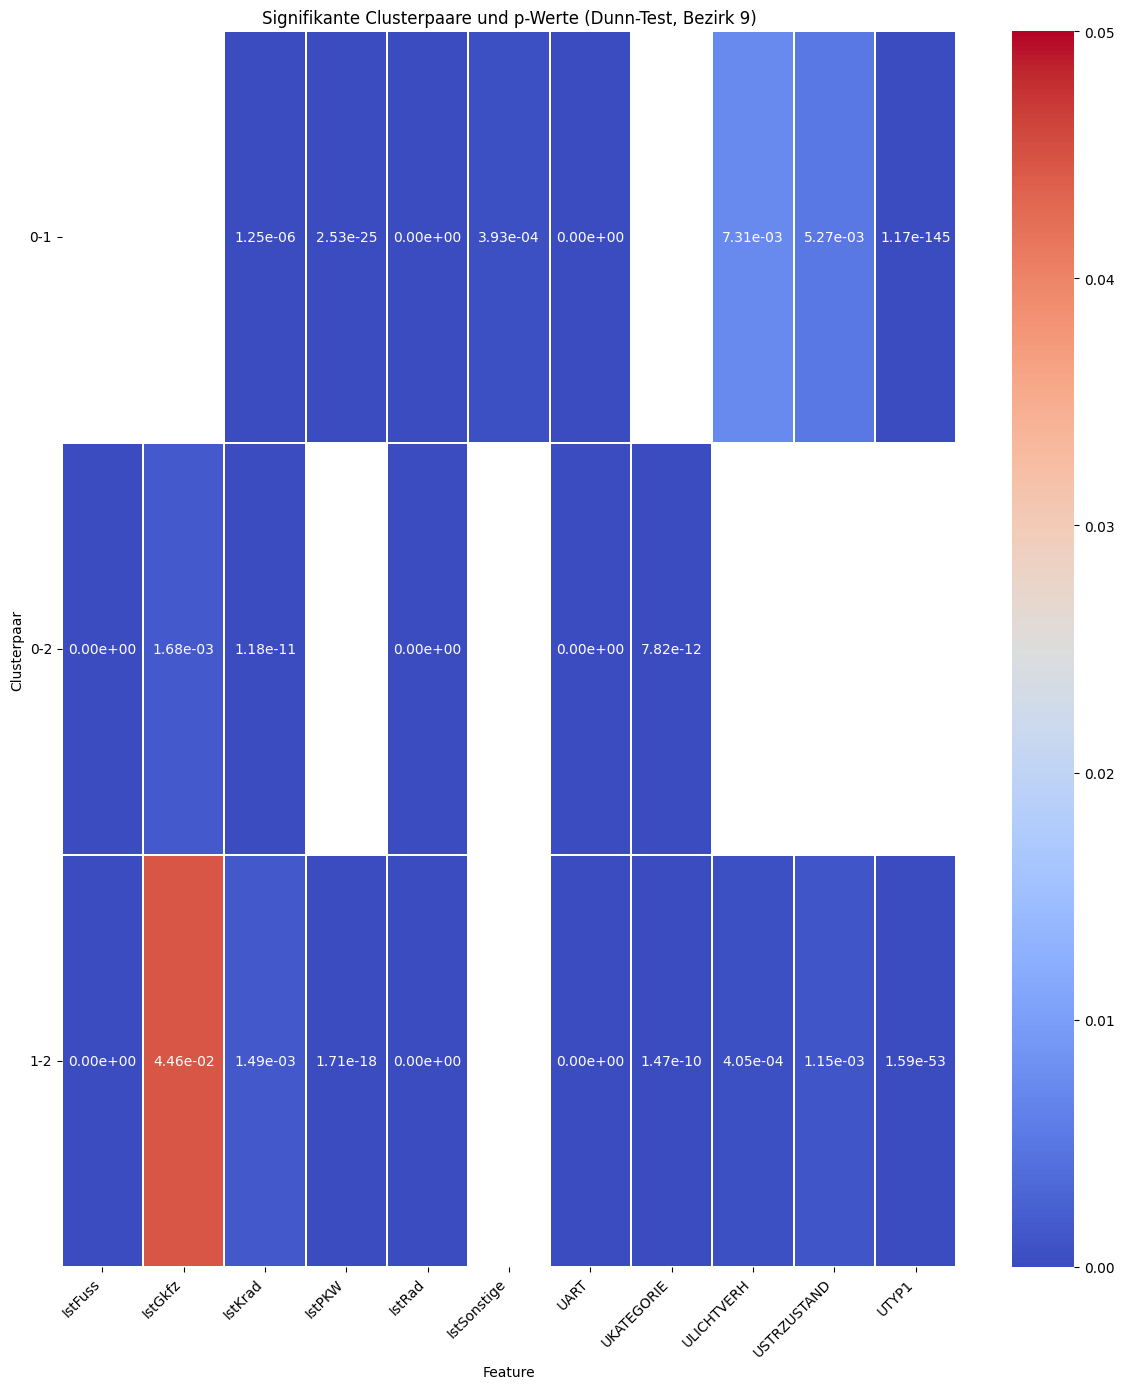

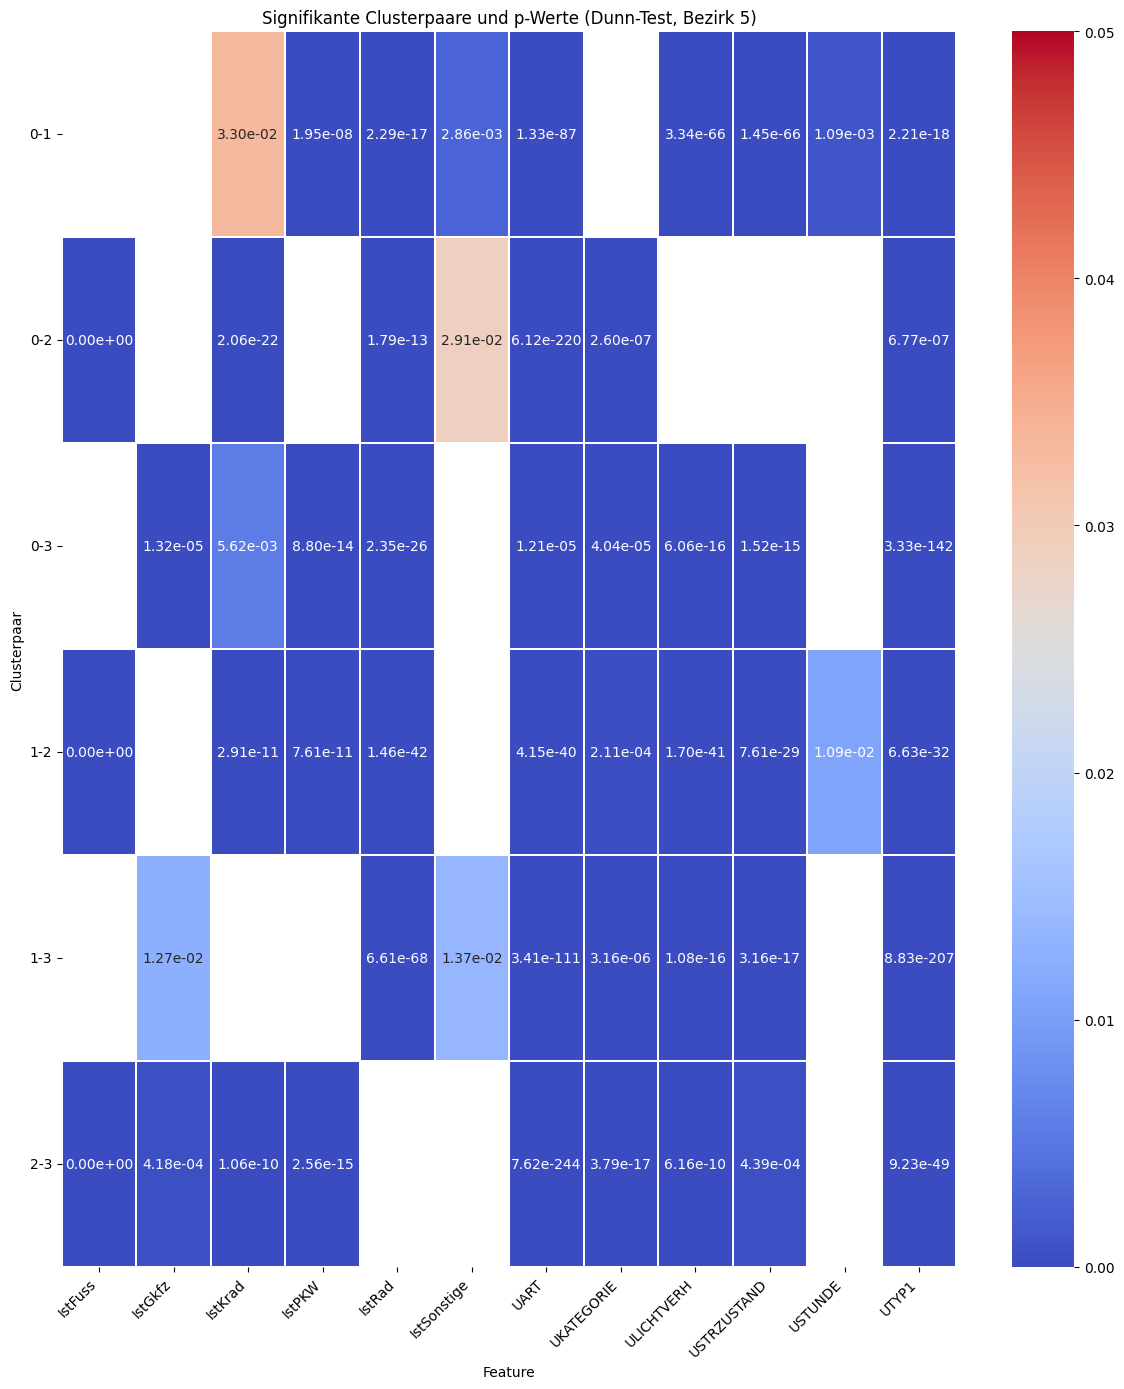

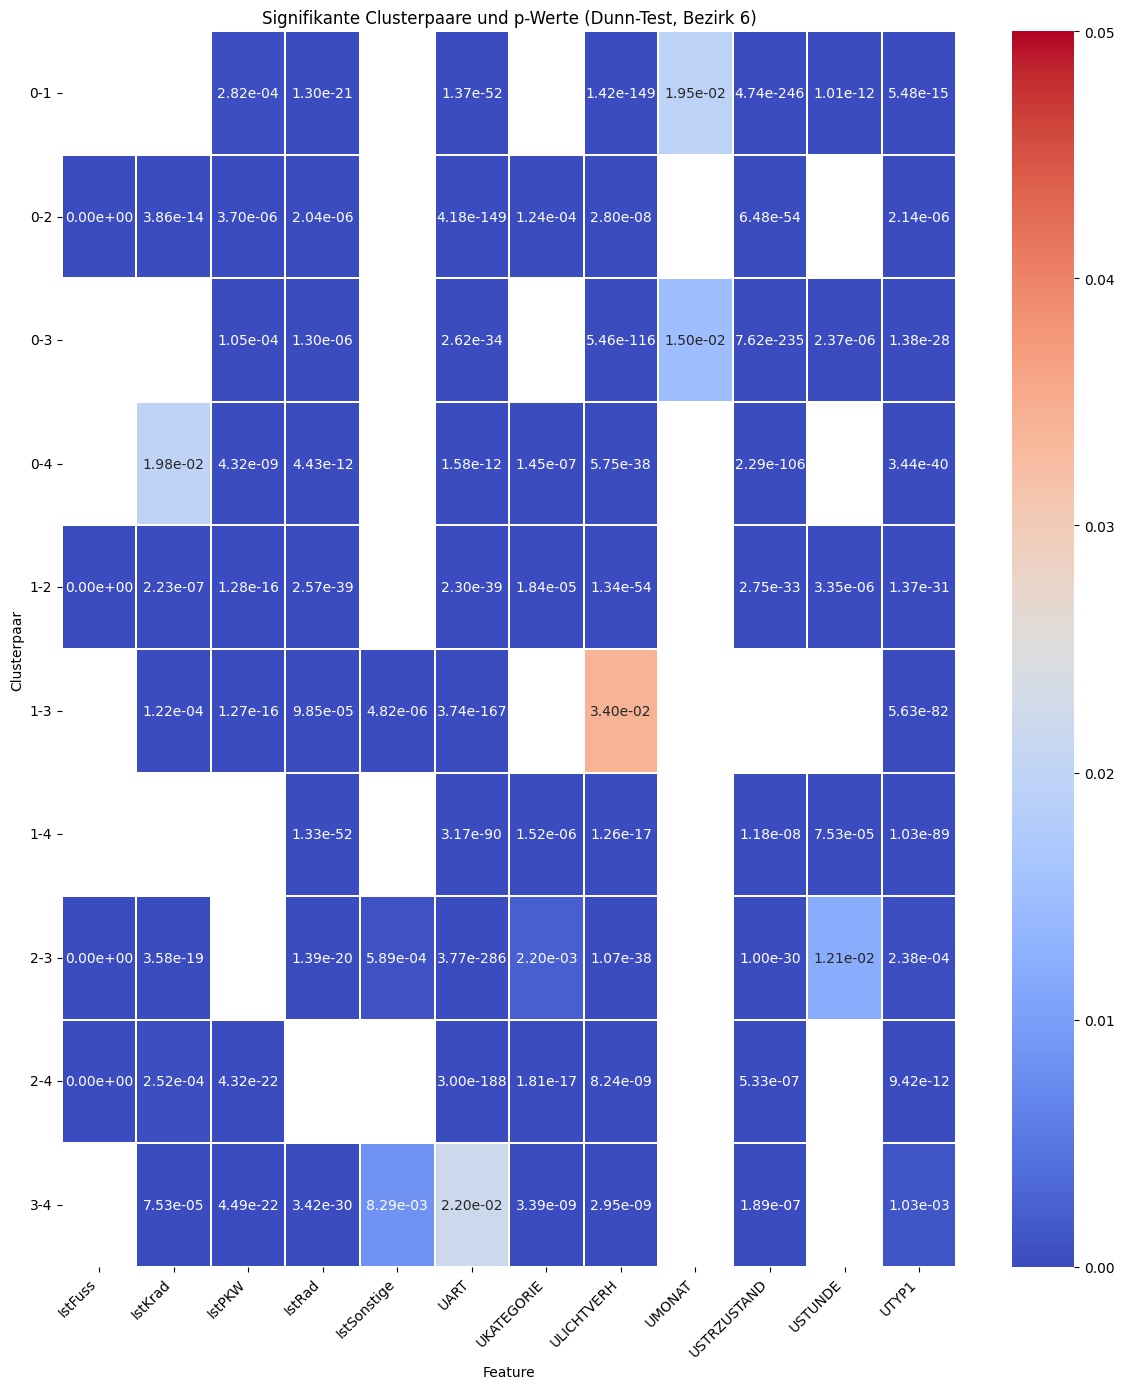

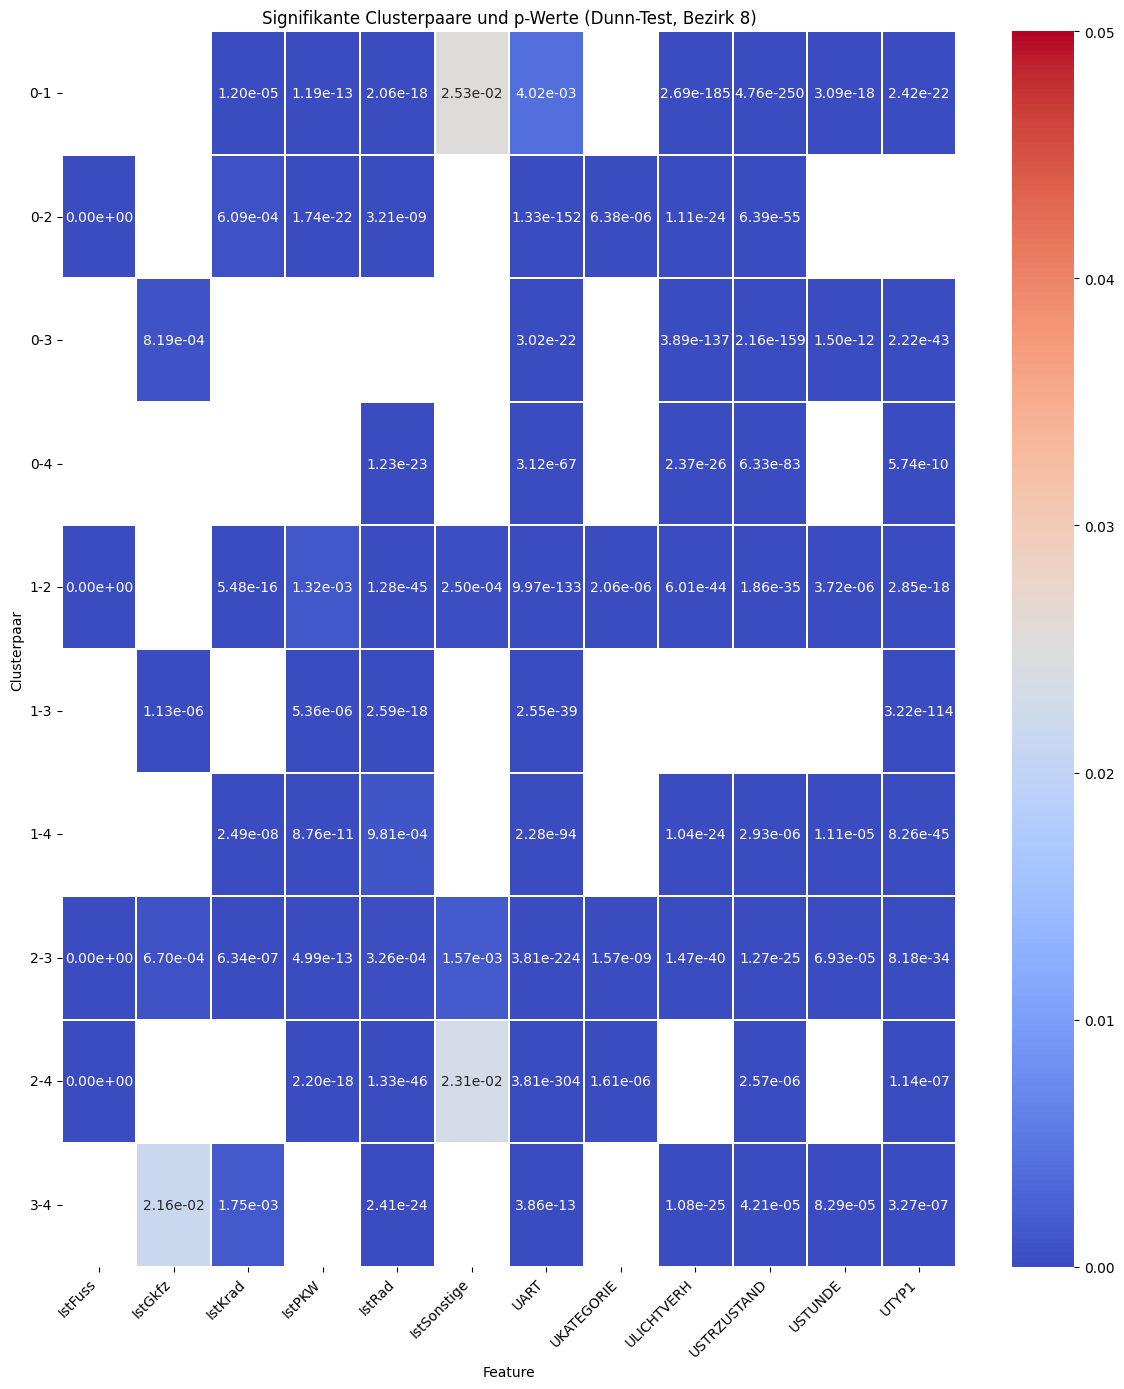

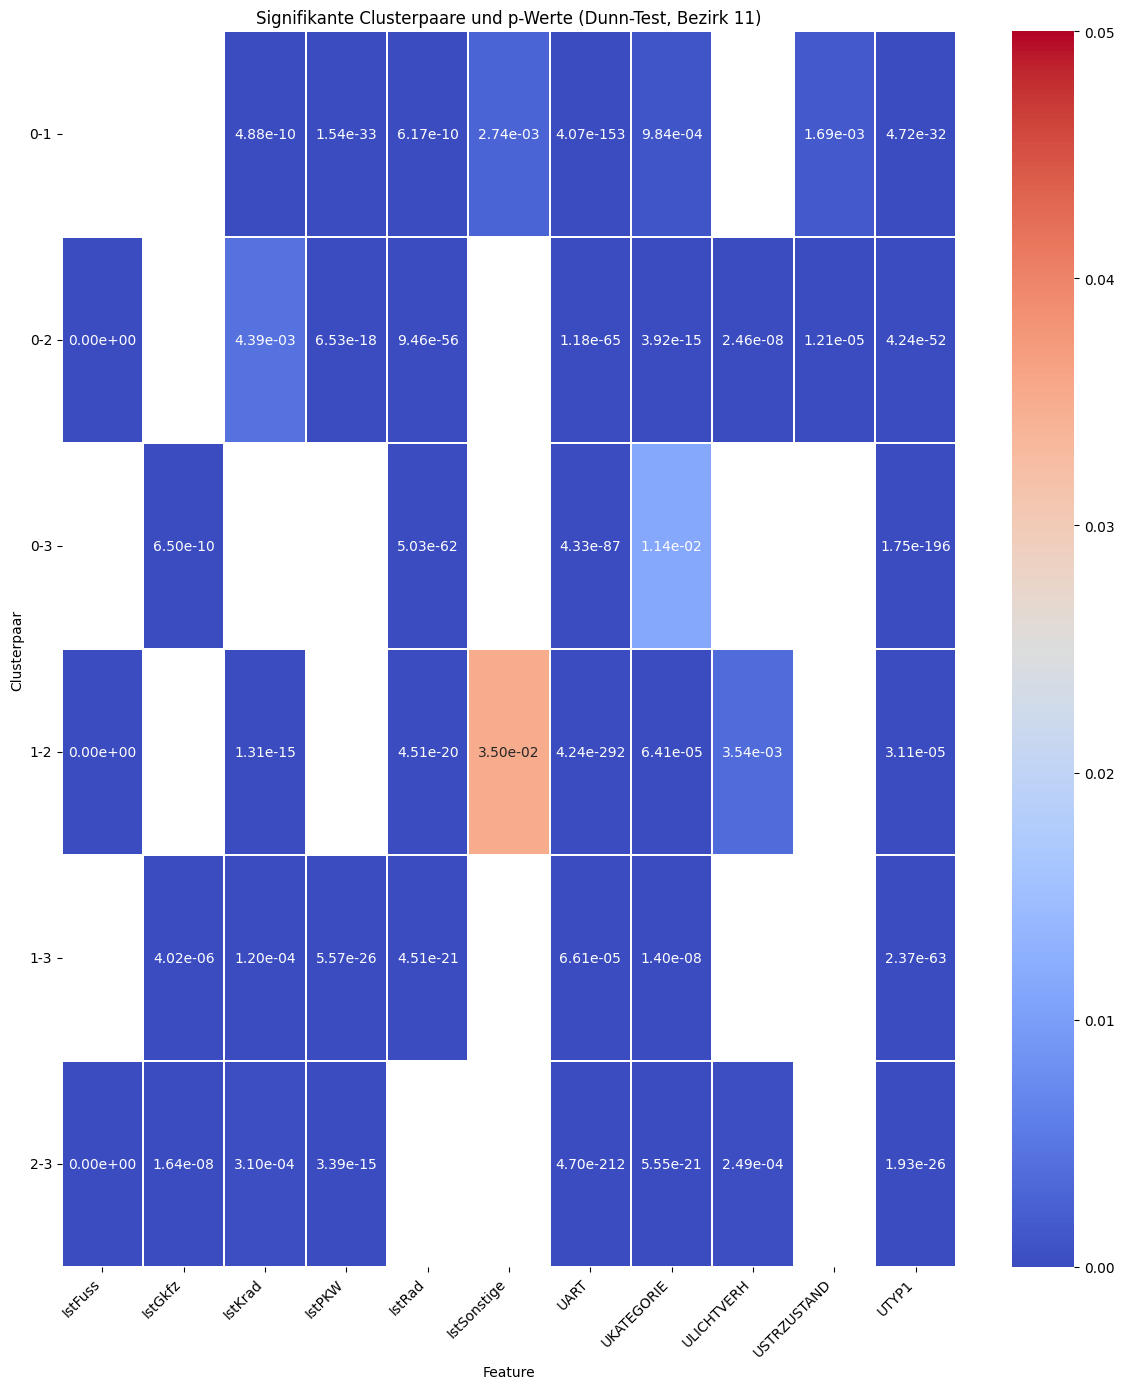

In [3]:
import pandas as pd  # Datenverarbeitung und Tabellenmanipulation
import numpy as np  # Numerische Berechnungen und Matrix-Operationen
import joblib  # Speichern und Laden von Modellen und Objekten

# Vorverarbeitung von Daten: Skalierung und Kategorisierung
from sklearn.preprocessing import MinMaxScaler  # Skalierung von numerischen Variablen auf einen Bereich (z. B. 0 bis 1)
from sklearn.preprocessing import OneHotEncoder  # Umwandlung kategorialer Variablen in numerische Dummy-Variablen

# Statistische Tests
from scipy.stats import kruskal  # Kruskal-Wallis-Test zur Überprüfung von Unterschieden zwischen Gruppen
import scikit_posthocs as sp  # Dunn-Test für paarweise Vergleiche

# Visualisierung
import matplotlib.pyplot as plt  # Erstellung von Diagrammen und Plots
import seaborn as sns  # Erweiterte Datenvisualisierung mit schöneren Diagrammen
import math  # Mathematische Funktionen 

# Die transformierten Daten
df_encoded = pd.read_csv("hierarchisch_final_clusters_pro_bezirk_mit_optimaler_anzahl.csv")

#  Clustering (ohne Geokoordinaten)
df_encoded = df_encoded.drop(columns=["XGCSWGS84", "YGCSWGS84"])

# Cluster-Spalte in ein NumPy-Array konvertieren (für Visualisierungs-Code)
agglo_labels = df_encoded["Cluster"].to_numpy()
np.save("hierarchisch_final_clusters_pro_bezirk.npy", agglo_labels)

# MinMaxScaler und OneHotEncoder
minmax_scaler = joblib.load("min_max_scaler.pkl")
onehot_encoder = joblib.load("onehot_encoder.pkl")

# -----------------------------
# Variablen definieren
# -----------------------------
numerical_vars = ['UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG']
ordinal_vars = ['UKATEGORIE']
nominal_vars = ['UART', 'UTYP1', 'ULICHTVERH', 'USTRZUSTAND']
binary_vars = ['IstRad', 'IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz', 'IstSonstige']

# Kombinierte Liste für kategoriale Variablen (nominal + ordinal)
categorical_vars = nominal_vars + ordinal_vars

# -----------------------------
# Daten zurücktransformieren
# -----------------------------
# Skalierte numerische Daten in Originalskala zurücktransformieren
df_encoded.loc[:, numerical_vars + ['UKATEGORIE']] = minmax_scaler.inverse_transform(
    df_encoded[numerical_vars + ['UKATEGORIE']]
)

# One-Hot-Encoding rückgängig machen (für nominale Variablen)
onehot_columns = onehot_encoder.get_feature_names_out(nominal_vars)
df_nominal = pd.DataFrame(onehot_encoder.inverse_transform(df_encoded[onehot_columns]),
                          columns=nominal_vars)

# Ursprüngliche One-Hot-Spalten entfernen und durch die dekodierten Spalten ersetzen
df_encoded = df_encoded.drop(columns=onehot_columns)
df_encoded = pd.concat([df_encoded, df_nominal], axis=1)

# Ordinale Variablen zurücktransformieren
df_encoded[numerical_vars + ['UKATEGORIE']] = minmax_scaler.inverse_transform(
    df_encoded[numerical_vars + ['UKATEGORIE']]
)

# Speichern der zurücktransformierten Daten (optional)
df_encoded.to_csv("kruskal_reversed_data.csv", index=False)

###############################
# Kruskal-Wallis-Test pro Bezirk
###############################
kruskal_results = []

for bez in sorted(df_encoded['BEZ'].unique()):
    print(f"\nKruskal-Wallis Test für Bezirk {bez}...")
    df_bezirk = df_encoded[df_encoded['BEZ'] == bez].copy()
    
    for feature in df_bezirk.columns:
        if feature in ["Cluster", "BEZ"]: 
            continue
        # Erstelle Gruppen basierend auf Clusterzuordnung
        groups = [df_bezirk[df_bezirk["Cluster"] == c][feature].dropna() 
                  for c in df_bezirk["Cluster"].unique()]
        groups = [g for g in groups if len(g) > 0]  # Leere Gruppen entfernen
        
        if len(groups) >= 2:  # Mindestens 2 Gruppen nötig
            stat, p_val = kruskal(*groups)
            kruskal_results.append({
                "BEZ": bez,
                "Feature": feature,
                "H-statistic": stat,
                "p-value": p_val
            })

# Ergebnisse speichern
kruskal_df = pd.DataFrame(kruskal_results).sort_values(by=["BEZ", "H-statistic"], ascending=[True, False])
print("\nKruskal-Wallis Test Ergebnisse pro Bezirk:\n", kruskal_df)

kruskal_df.to_csv("Kruskal-Wallis_results_agglo_per_bezirk.csv", index=False)

significant_features = kruskal_df[kruskal_df['p-value'] < 0.05]['Feature']
print(f"Anzahl der signifikanten Features: {len(significant_features)}")

# -------------------------------------------
# Dunn-Test für signifikante Merkmale
# -------------------------------------------
dunn_results = {}

# Hier werden die Features mit einem p-value < 0.05 aus dem Kruskal-Wallis-Test gefiltert
significant_features = kruskal_df[kruskal_df["p-value"] < 0.05]

for bezirk in df_encoded['BEZ'].unique():  # Dunn-Test pro Bezirk
    for feature in significant_features["Feature"]:
        # Dunn-Test für jedes signifikante Feature durchführen
        dunn_results[bezirk] = dunn_results.get(bezirk, {})
        dunn_results[bezirk][feature] = sp.posthoc_dunn(
            df_encoded[df_encoded['BEZ'] == bezirk], val_col=feature, group_col='Cluster', p_adjust='bonferroni'
        )

# Speichern der Dunn-Test-Ergebnisse und signifikanten Paare in Excel
with pd.ExcelWriter("Dunn_Test_results_per_bezirk.xlsx") as writer:
    # Schreibe die Dunn-Test-Ergebnisse für jedes Feature in einem eigenen Blatt
    for bezirk, features in dunn_results.items():
        for feature, df in features.items():
            df.to_excel(writer, sheet_name=f"{bezirk}_{feature[:31]}_results")  # Maximale Länge des Tabellennamens ist 31

# -------------------------------------------
# 7. Visualisierung der Anzahl signifikanter Clusterpaare
# -------------------------------------------
import collections

for bezirk in dunn_results.keys():
    feature_pair_counter = collections.defaultdict(set)

    for feature, df in dunn_results[bezirk].items():
        mask = np.triu(np.ones(df.shape), k=1).astype(bool)
        unique_p_values = df.where(mask)

        for (i, j), pvalue in unique_p_values.stack().items():
            if pvalue < 0.05:
                pair = tuple(sorted((i, j)))  # Doppelte vermeiden
                feature_pair_counter[feature].add(pair)

    # Zähle die Anzahl signifikanter Clusterpaare pro Feature
    feature_counts = {feature: len(pairs) for feature, pairs in feature_pair_counter.items()}
    feature_counts_sorted = dict(sorted(feature_counts.items(), key=lambda x: x[1], reverse=True))

    # Visualisierung – ACHSEN GEDREHT: Feature auf X-Achse, Werte auf Y-Achse
    plt.figure(figsize=(12, 6))
    plt.bar(feature_counts_sorted.keys(), feature_counts_sorted.values(), color='cornflowerblue')
    plt.ylabel('Anzahl signifikanter Clusterpaare (p < 0.05)')
    plt.xlabel('Feature')
    plt.title(f'Signifikante Unterschiede nach Feature (Dunn-Test, Bezirk {bezirk})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"output/plots/Dunn_Signifikante_Features_Bezirk_{bezirk}_vertikal.png", dpi=100, bbox_inches="tight")
    plt.show()

# -------------------------------------------
# 8. Heatmap signifikanter Clusterpaare pro Bezirk
# -------------------------------------------
for bezirk in dunn_results.keys():
    significant_pairs_with_pvalues = []
    for feature, df in dunn_results[bezirk].items():
        sig = df[df < 0.05].stack()
        for (i, j), pvalue in sig.items():
            if i < j:
                significant_pairs_with_pvalues.append((i, j, feature, pvalue))

    significant_pairs_with_pvalues_df = pd.DataFrame(
        significant_pairs_with_pvalues, columns=['Cluster A', 'Cluster B', 'Feature', 'p-value']
    )

    heatmap_data_pvalues = significant_pairs_with_pvalues_df.pivot_table(
        index=['Cluster A', 'Cluster B'], columns='Feature', values='p-value', aggfunc='min', fill_value=np.nan
    )

    plt.figure(figsize=(12, 14))
    sns.heatmap(
        heatmap_data_pvalues, cmap='coolwarm', annot=True, fmt='.2e',
        linewidths=0.1, vmin=0, vmax=0.05
    )
    plt.xlabel('Feature')
    plt.ylabel('Clusterpaar')
    plt.title(f'Signifikante Clusterpaare und p-Werte (Dunn-Test, Bezirk {bezirk})')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"output/plots/Signifikante_Clusterpaare_und_p-Werte_{bezirk}_nach_Dunn-Test.png", dpi=100, bbox_inches="tight")
    plt.show()

    significant_pairs_with_pvalues_df.to_csv(f"Signifikante_Clusterpaare_mit_p_Werten_{bezirk}.csv", index=False)
